# SVM

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sys
sys.path.append("../scripts")
from data_cleaning import clean_data

ModuleNotFoundError: No module named 'data_cleaning'

In [ ]:
#train
train_raw = pd.read_csv("../data/train.csv")
train_clean = clean_data(train_raw)
train_clean.to_csv("../data/train_clean.csv", index=False)

#test
test_raw = pd.read_csv("../data/test.csv")
test_clean = clean_data(test_raw)
test_clean.to_csv("../data/test_clean.csv", index=False)

print("Saved train_clean.csv and test_clean.csv")

In [2]:
df = pd.read_csv('../data/train_clean.csv')
# df = pd.read_csv('../data/train.csv')

In [3]:
# EDA

print(df['rating_rejected'].head())

print("\n")

print(df.columns)

print("\n")

print(np.min(df['rating_rejected']), np.max(df['rating_rejected']))


for idx, text in df["comment_text"].head(5).items():
    print(idx, text)

0    0
1    0
2    1
3    0
4    0
Name: rating_rejected, dtype: int64


Index(['comment_text', 'funny', 'wow', 'sad', 'likes', 'disagree', 'toxicity',
       'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack',
       'insult', 'threat', 'toxicity_annotator_count', 'rating_rejected'],
      dtype='object')


0 1
0 That was the reason Walker fire everyone now what ?.
1 So my original statement still stands . A church needs to not get involved in supporting Candidate A as opposed to Candidate B, it must however must make a stand on the side of the Gospel and help its congregation be informed and allow it to vote on that basis...
2 All you ever do is come to these forums berating white people with your Critical Race Theory garbage.

Please study Islamic Law before stupidly comparing someone you speculate is fueled by a verboten emotion to ISIS. 

Good grief, study something more than CRT.
3 Tonight will be an excellent opportunity for Clayton Kershaw to show that his bad p

## SVC

In [3]:
# making label of rating_rejected feature into binary from continuous (0.0 to 1.0)

df["comment_text"] = df["comment_text"].fillna("").astype(str)
df["label"] = df["rating_rejected"]

In [4]:
# chosen columns
# cols = ['rating', 'funny', 'wow', 'sad', 'likes',
#        'disagree', 'sexual_explicit',
#        'male', 'female', 'transgender',
#        'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
#        'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
#        'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
#        'latino', 'other_race_or_ethnicity', 'physical_disability',
#        'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
#        'other_disability']

text_col = "comment_text"
df[text_col] = df[text_col].fillna("").astype(str)

y = df["label"]

cols = [
    c for c in df.columns
    if c not in [text_col, "label", "rating_rejected"]
]

# df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
# df[cols] = df[cols].fillna(0)

print("Columns in cleaned df:", df.columns.tolist())
print("Numeric feature columns (first few):", cols[:10])

Columns in cleaned df: ['comment_text', 'funny', 'wow', 'sad', 'likes', 'disagree', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat', 'toxicity_annotator_count', 'rating_rejected', 'label']
Numeric feature columns (first few): ['funny', 'wow', 'sad', 'likes', 'disagree', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack']


In [5]:
train_idx, val_idx = train_test_split(
    df.index,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [6]:
y_train = df["label"].loc[train_idx]
y_val = df["label"].loc[val_idx]

### Just text

In [10]:
# train test split (already done in data_prep.py and data_cleaning.py in ./scripts)
X_train_text = df.loc[train_idx, "comment_text"]
X_val_text   = df.loc[val_idx, "comment_text"]

In [11]:
# just LinearSVC with text in X_train or X_test
clf_text = Pipeline([
    ("tfidf", TfidfVectorizer( # strings to numeric
        stop_words="english",
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.9
    )),
    ("svm", LinearSVC(random_state=42)) # regular linearSVC algorithm
])

clf_text.fit(X_train_text, y_train)
y_pred_text = clf_text.predict(X_val_text)

print(accuracy_score(y_val, y_pred_text))
print(classification_report(y_val, y_pred_text))


0.9351725739535409
              precision    recall  f1-score   support

           0       0.94      0.99      0.97    297694
           1       0.53      0.11      0.18     20952

    accuracy                           0.94    318646
   macro avg       0.74      0.55      0.57    318646
weighted avg       0.91      0.94      0.91    318646



### Other columns and text

In [7]:
X_train_both = df.loc[train_idx, ["comment_text"] + cols]
X_val_both   = df.loc[val_idx, ["comment_text"] + cols]

In [ ]:
# LinearSVC with text and other columns
preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2)
        ), "comment_text"),
        ("num", StandardScaler(), cols),
    ]
)

clf_both = Pipeline([
    ("preprocess", preprocess),
    ("svm", LinearSVC(random_state=42))
])

clf_both.fit(X_train_both, y_train)
y_pred_both = clf_both.predict(X_val_both)

print(accuracy_score(y_val, y_pred_both))
print(classification_report(y_val, y_pred_both))

### Just other columns

In [ ]:
X_train_num = df.loc[train_idx, cols]
X_val_num   = df.loc[val_idx, cols]

In [ ]:
# LinearSVC withOUT text and just other columns
clf_num = Pipeline([
    ("ss", StandardScaler()),
    ("svm", LinearSVC(random_state=42))
])

clf_num.fit(X_train_num, y_train)
y_pred_num = clf_num.predict(X_val_num)

print(accuracy_score(y_val, y_pred_num))
print(classification_report(y_val, y_pred_num))

## Optimizing just Both Comment and Columns SVC:

In [8]:
# proprocess and pipeline build
preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            stop_words="english"
        ), "comment_text"),
        ("num", StandardScaler(), cols),
    ]
)

base_svm_both = Pipeline([
    ("preprocess", preprocess),
    ("svm", LinearSVC(random_state=42, max_iter=10000))
])

In [10]:
# Hyperparameter grid for combined model
param_grid_both = {
    "preprocess__text__ngram_range": [(1, 2)],
    "preprocess__text__min_df": [5, 10],
    "svm__C": [0.5, 1, 2]
}

# actual optimization through GridSearchCV
grid_both = GridSearchCV(
    estimator=base_svm_both,
    param_grid=param_grid_both,
    cv=3, 
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

# X_train_both and y_train from  unified split
# grid_both.fit(X_train_both, y_train)

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
small_idx, _ = next(sss.split(X_train_both, y_train))

X_train_small = X_train_both.iloc[small_idx]
y_train_small = y_train.iloc[small_idx]

grid_both.fit(X_train_small, y_train_small)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'preprocess__text__min_df': [5, 10], 'preprocess__text__ngram_range': [(1, ...)], 'svm__C': [0.5, 1, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('text', ...), ('num', ...)]"


[CV] END preprocess__text__min_df=5, preprocess__text__ngram_range=(1, 2), svm__C=0.5; total time=  43.9s
[CV] END preprocess__text__min_df=10, preprocess__text__ngram_range=(1, 2), svm__C=0.5; total time=  37.3s
[CV] END preprocess__text__min_df=10, preprocess__text__ngram_range=(1, 2), svm__C=1; total time=  41.3s
[CV] END preprocess__text__min_df=5, preprocess__text__ngram_range=(1, 2), svm__C=1; total time=  45.4s
[CV] END preprocess__text__min_df=10, preprocess__text__ngram_range=(1, 2), svm__C=0.5; total time=  35.9s
[CV] END preprocess__text__min_df=10, preprocess__text__ngram_range=(1, 2), svm__C=1; total time=  42.6s
[CV] END preprocess__text__min_df=5, preprocess__text__ngram_range=(1, 2), svm__C=0.5; total time=  43.7s
[CV] END preprocess__text__min_df=5, preprocess__text__ngram_range=(1, 2), svm__C=2; total time=  46.8s
[CV] END preprocess__text__min_df=10, preprocess__text__ngram_range=(1, 2), svm__C=1; total time=  43.6s
[CV] END preprocess__text__min_df=5, preprocess__te

In [11]:
# print the parameters and scores for best parameters
print("Best params (combined SVM):", grid_both.best_params_)
print("Best CV F1 (combined SVM):", grid_both.best_score_)

best_svm_both = grid_both.best_estimator_

# Evaluate on the validation set
y_val_pred_both = best_svm_both.predict(X_val_both)

print("Validation accuracy (combined, tuned):", accuracy_score(y_val, y_val_pred_both))
print(classification_report(y_val, y_val_pred_both))

Best params (combined SVM): {'preprocess__text__min_df': 5, 'preprocess__text__ngram_range': (1, 2), 'svm__C': 2}
Best CV F1 (combined SVM): 0.24617427527032318
[CV] END preprocess__text__min_df=5, preprocess__text__ngram_range=(1, 2), svm__C=1; total time=  53.2s
[CV] END preprocess__text__min_df=10, preprocess__text__ngram_range=(1, 2), svm__C=0.5; total time=  40.6s
[CV] END preprocess__text__min_df=10, preprocess__text__ngram_range=(1, 2), svm__C=2; total time=  48.8s
[CV] END preprocess__text__min_df=5, preprocess__text__ngram_range=(1, 2), svm__C=0.5; total time=  39.7s
[CV] END preprocess__text__min_df=5, preprocess__text__ngram_range=(1, 2), svm__C=2; total time=  56.3s
[CV] END preprocess__text__min_df=10, preprocess__text__ngram_range=(1, 2), svm__C=2; total time=  53.4s
Validation accuracy (combined, tuned): 0.9307632921800367
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    297694
           1       0.44      0.18      0.

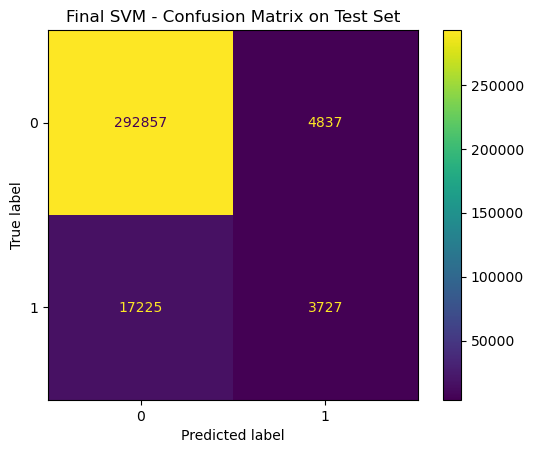

In [12]:
# confusion matrix for best SVC model:
cm = confusion_matrix(y_val, y_val_pred_both)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Final SVM - Confusion Matrix on Test Set")
plt.show()

With Support Vector Machine, we used the SVC model from sklearn to classify observations from the dataset into toxic or not toxic. Here, we tested training with varying columns. First, we trained with just the `comment_text` in the X, then `comment_text` and numeric variables as X with ColumnTransformer function, and finally just numeric variables as X. It appeared that, with the same conditions, using both `comment_text` and numeric variables in X were the best. So we optimized using GridSearchCV to find the best hyperparameter values. Pipeline from sklearn was also used to simplify and standardize the different model variations. 

Since we optimized on both `comment_text` and numeric variables, we decided to do the same conditions for X training and validating in the other 3 models (NN, Ensemble, and Regression). The best parameters on a stratified dataset were {'preprocess__text__min_df': 5, 'preprocess__text__ngram_range': (1, 2), 'svm__C': 2} with an F1 score of 0.25 for toxic accuracy and an accuracy score of 0.9307632921800367, one of the best text + numeric models. Neural network does use a slightly different method for encoding the `comment_text` to use in the model training and validation, but it is theoretically the same. We also tried numeric only for nn, which yielded some promising results compared to text and numeric columns alone. This will be explained in the NN designated notebook.